# ODIN
[facebookresearch/odin](https://github.com/facebookresearch/odin)

In [1]:
import torch
import torchvision
import torchmetrics
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append("./code")

from odin import ODIN

device = torch.device('cuda:0')

## Datasets

* [Tiny-ImageNet (crop)](https://www.dropbox.com/s/avgm2u562itwpkl/Imagenet.tar.gz)
* [Tiny-ImageNet (resize)](https://www.dropbox.com/s/kp3my3412u5k9rl/Imagenet_resize.tar.gz)
* [LSUN (crop)](https://www.dropbox.com/s/fhtsw1m3qxlwj6h/LSUN.tar.gz)
* [LSUN (resize)](https://www.dropbox.com/s/moqh2wh8696c3yl/LSUN_resize.tar.gz)
* [iSUN](https://www.dropbox.com/s/ssz7qxfqae0cca5/iSUN.tar.gz)

```bash
sh download_data.sh
```

* Use 1000 elements of the entire test-set as validation-set.

In [2]:
# Datasets
mean = (125.3/255, 123.0/255, 113.9/255)
std = (63.0/255, 62.1/255.0, 66.7/255.0)
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(mean, std),
])

nm_datasets = ['Imagenet', 'Imagenet_resize', 'LSUN', 'LSUN_resize', 'iSUN']

datasets = {
  nm: torchvision.datasets.ImageFolder(f'./data/{nm}/', transform=transform)
  for nm in nm_datasets
}
datasets.update({
  'cifar10': torchvision.datasets.CIFAR10(root='./data/', train=False, download=True, transform=transform),
  'cifar100': torchvision.datasets.CIFAR100(root='./data/', train=False, download=True, transform=transform),
})

valset = {
  k: torch.utils.data.Subset(v, range(1000)) for k,v in datasets.items()
}

testset = {
  k: torch.utils.data.Subset(v, range(1000,10000)) for k,v in datasets.items()
}

valloaders = {
  k: torch.utils.data.DataLoader(v, batch_size=64, shuffle=False)
  for k, v in valset.items()
}

testloaders = {
  k: torch.utils.data.DataLoader(v, batch_size=64, shuffle=False)
  for k, v in testset.items()
}

Files already downloaded and verified
Files already downloaded and verified


## Models

* [DenseNet-BC trained on CIFAR-10](https://www.dropbox.com/s/wr4kjintq1tmorr/densenet10.pth.tar.gz)
* [DenseNet-BC trained on CIFAR-100](https://www.dropbox.com/s/vxuv11jjg8bw2v9/densenet100.pth.tar.gz)
* [Wide ResNet trained on CIFAR-10](https://www.dropbox.com/s/uiye5nw0uj6ie53/wideresnet10.pth.tar.gz)
* [Wide ResNet trained on CIFAR-100](https://www.dropbox.com/s/elfw7e3uofpydg5/wideresnet100.pth.tar.gz)

```bash
mkdir models
cd models
wget https://www.dropbox.com/s/wr4kjintq1tmorr/densenet10.pth.tar.gz
tar -xvzf densenet10.pth.tar.gz
cd ..
```

We can use any other pytorch models.

In [3]:
# Models
nm_models = [
  'densenet10', 'densenet100',
  # 'wideresnet10', 'wideresnet100',
]
models = {
  nm: torch.load(f'./models/{nm}.pth', map_location='cpu').eval() for nm in nm_models
}

/home/bckim/miniconda3/envs/jax/lib/python3.10/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/bckim/miniconda3/envs/jax/lib/python3.10/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/bckim/miniconda3/envs/jax/lib/python3.10/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the

## Accuracy (test error rate)
* on the entire test-set of `CIFAR10` and `CIFAR100` respectively.

In [4]:
cifar10_dl = torch.utils.data.DataLoader(datasets['cifar10'], batch_size=64, shuffle=False, num_workers=2)
cifar100_dl = torch.utils.data.DataLoader(datasets['cifar100'], batch_size=64, shuffle=False, num_workers=2)

acc10 = torchmetrics.Accuracy(task="multiclass", num_classes=10)
acc100 = torchmetrics.Accuracy(task="multiclass", num_classes=100)

@torch.no_grad()
def accuracy(model, dataloader, metric, device='cuda:0'):
  model.eval()
  model.to(device)
  metric.to(device)
  
  with tqdm(dataloader) as pbar:
    for imgs, targets in pbar:
      imgs, targets = imgs.to(device), targets.to(device)
      preds = model(imgs).softmax(dim=-1)
      m = metric(preds, targets)
      m = metric.compute()
      pbar.set_postfix({'accuracy': m.item()})
  return m

In [5]:
err_rate = 1 - accuracy(models['densenet10'], cifar10_dl, acc10, device=device)
acc10.reset()
err_rate.item()

  0%|          | 0/157 [00:00<?, ?it/s]

0.04809999465942383

In [6]:
err_rate = 1 - accuracy(models['densenet100'], cifar100_dl, acc100, device=device)
acc100.reset()
err_rate.item()

  0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcb878de050>
Traceback (most recent call last):
  File "/home/bckim/miniconda3/envs/jax/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/bckim/miniconda3/envs/jax/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/bckim/miniconda3/envs/jax/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcb878de050>
Traceback (most recent call last):
  File "/home/bckim/miniconda3/envs/jax/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/bckim/miniconda3/envs/jax/lib/python3.10/site-p

0.22380000352859497

## Results

* DenseNet-BC with CIFAR100

### Original Model

In [7]:
no_odin = ODIN(models['densenet100'], epsilon=0., T=1, device=device)
no_odin.run(testloaders['cifar100'], testloaders['Imagenet'], prog_bar=True, postfix=False)

In-dist:   0%|          | 0/141 [00:00<?, ?it/s]

/home/bckim/miniconda3/envs/jax/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Out-of-dist:   0%|          | 0/141 [00:00<?, ?it/s]

/home/bckim/miniconda3/envs/jax/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


{'FPR@95': 0.6684444546699524,
 'DErr': 0.2702222168445587,
 'AUROC': 0.8114825487136841,
 'AUPR_In': 0.8290560841560364,
 'AUPR_Out': 0.8013123869895935}

### ODIN

In [8]:
odin = ODIN(models['densenet100'], epsilon=0.002, T=1000, device=device)
odin.run(testloaders['cifar100'], testloaders['Imagenet'], prog_bar=True, postfix=False)

In-dist:   0%|          | 0/141 [00:00<?, ?it/s]

Out-of-dist:   0%|          | 0/141 [00:00<?, ?it/s]

{'FPR@95': 0.2674444317817688,
 'DErr': 0.12905555963516235,
 'AUROC': 0.9449045658111572,
 'AUPR_In': 0.9467122554779053,
 'AUPR_Out': 0.9445734024047852}

### ODIN without Temperature Scaling (only input processing)

In [9]:
odin_no_temp = ODIN(models['densenet100'], epsilon=0.002, T=1, device=device)
odin_no_temp.run(testloaders['cifar100'], testloaders['Imagenet'], prog_bar=True, postfix=False)

In-dist:   0%|          | 0/141 [00:00<?, ?it/s]

Out-of-dist:   0%|          | 0/141 [00:00<?, ?it/s]

{'FPR@95': 0.5222222208976746,
 'DErr': 0.2096666693687439,
 'AUROC': 0.8764071464538574,
 'AUPR_In': 0.8843724131584167,
 'AUPR_Out': 0.8684892654418945}

### ODIN without Input Processing (only temperature scaling)

In [10]:
odin_no_input = ODIN(models['densenet100'], epsilon=0., T=1000, device=device)
odin_no_input.run(testloaders['cifar100'], testloaders['Imagenet'], prog_bar=True, postfix=False)

In-dist:   0%|          | 0/141 [00:00<?, ?it/s]

Out-of-dist:   0%|          | 0/141 [00:00<?, ?it/s]

{'FPR@95': 0.4112222194671631,
 'DErr': 0.1702222228050232,
 'AUROC': 0.9105525612831116,
 'AUPR_In': 0.9133973717689514,
 'AUPR_Out': 0.9099268913269043}

### Summary

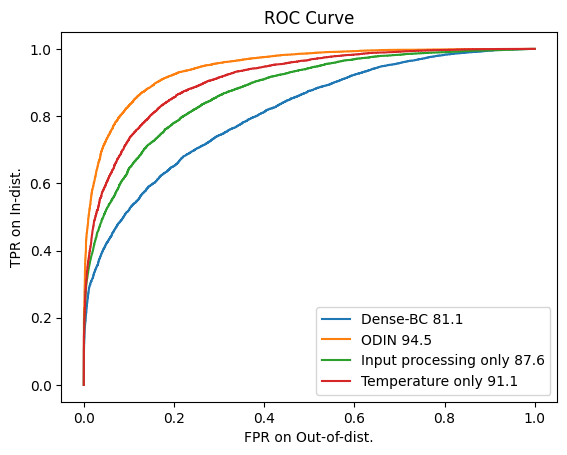

0.8114825487136841 0.9449045658111572 0.8764071464538574 0.9105525612831116


In [11]:
plt.title("ROC Curve")
plt.xlabel("FPR on Out-of-dist.")
plt.ylabel("TPR on In-dist.")
auroc1 = no_odin.auroc(plot=True, label=f'Dense-BC {no_odin.auroc().item()*100:.1f}').item()
auroc2 = odin.auroc(plot=True, label=f'ODIN {odin.auroc().item()*100:.1f}').item()
auroc3 = odin_no_temp.auroc(plot=True, label=f'Input processing only {odin_no_temp.auroc().item()*100:.1f}').item()
auroc4 = odin_no_input.auroc(plot=True, label=f'Temperature only {odin_no_input.auroc().item()*100:.1f}').item()
plt.legend()
plt.show()
print(auroc1, auroc2, auroc3, auroc4)

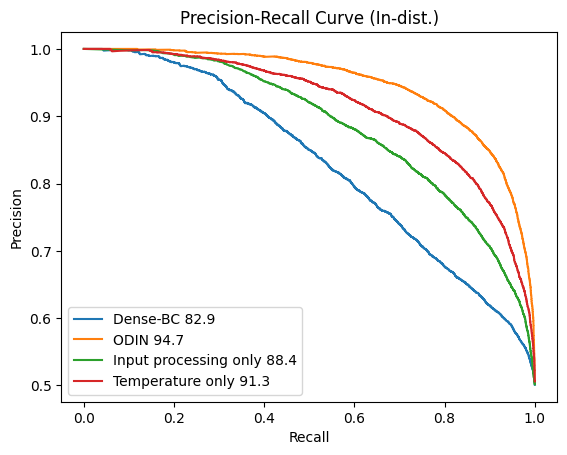

0.8290560841560364 0.9467122554779053 0.8843724131584167 0.9133973717689514


In [12]:
plt.title("Precision-Recall Curve (In-dist.)")
plt.xlabel("Recall")
plt.ylabel("Precision")
aupr1 = no_odin.aupr_in(plot=True, label=f'Dense-BC {no_odin.aupr_in().item()*100:.1f}').item()
aupr2 = odin.aupr_in(plot=True, label=f'ODIN {odin.aupr_in().item()*100:.1f}').item()
aupr3 = odin_no_temp.aupr_in(plot=True, label=f'Input processing only {odin_no_temp.aupr_in().item()*100:.1f}').item()
aupr4 = odin_no_input.aupr_in(plot=True, label=f'Temperature only {odin_no_input.aupr_in().item()*100:.1f}').item()
plt.legend()
plt.show()
print(aupr1, aupr2, aupr3, aupr4)

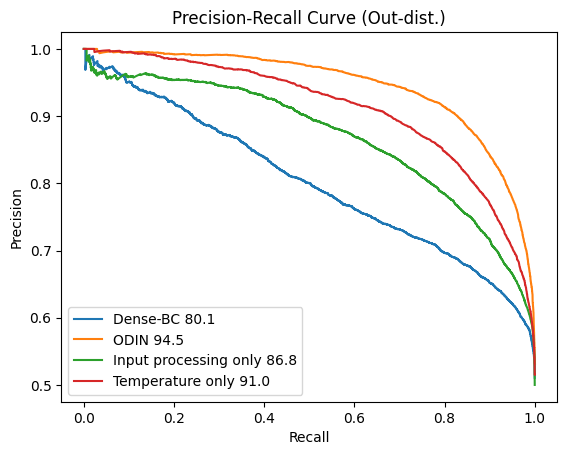

0.8013123869895935 0.9445734024047852 0.8684892654418945 0.9099268913269043


In [13]:
plt.title("Precision-Recall Curve (Out-dist.)")
plt.xlabel("Recall")
plt.ylabel("Precision")
aupr1 = no_odin.aupr_out(plot=True, label=f'Dense-BC {no_odin.aupr_out().item()*100:.1f}').item()
aupr2 = odin.aupr_out(plot=True, label=f'ODIN {odin.aupr_out().item()*100:.1f}').item()
aupr3 = odin_no_temp.aupr_out(plot=True, label=f'Input processing only {odin_no_temp.aupr_out().item()*100:.1f}').item()
aupr4 = odin_no_input.aupr_out(plot=True, label=f'Temperature only {odin_no_input.aupr_out().item()*100:.1f}').item()
plt.legend()
plt.show()
print(aupr1, aupr2, aupr3, aupr4)